<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [236]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [237]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [238]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [240]:
#df=pd.read_excel("BG_Dataset/BG_sample27.xlsx")

In [241]:
# Colab
df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_sample4.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")


In [242]:
df.shape

(1987, 14)

In [243]:
df.head(13)

,색인,타임스탬프(YYYY-MM-DDThh:mm:ss),이벤트 유형,이벤트 하위 유형,환자 정보,장치 정보,소스 장치 ID,포도당 값 (mg/dL),인슐린 값(u),탄수화물 값 (그램),기간(hh:mm:ss),포도당 변화율 (mg/dL/min),트랜스미터 시간 (배장 정수),트랜스미터 ID
0,1,NaN,이름,NaN,sch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,성,NaN,s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,생년월일,NaN,1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,장치,NaN,NaN,Dexcom G5 Mobile App,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,경고,하락,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
5,6,NaN,경고,높음,NaN,NaN,Android,400.0,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,경고,낮음,NaN,NaN,Android,60.0,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,경고,신호 손실,NaN,NaN,Android,NaN,NaN,NaN,00:30:00,NaN,NaN,NaN
8,9,NaN,경고,상승,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
9,10,NaN,경고,매우 낮음,NaN,NaN,Android,55.0,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [245]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [246]:
df['Event'].value_counts()

EGV     1911
교정        33
인슐린       19
탄수화물      14
경고         6
생년월일       1
이름         1
장치         1
성          1
Name: Event, dtype: int64

In [247]:
df['Glucose'].value_counts()

155.0    30
116.0    25
118.0    22
117.0    22
120.0    22
         ..
315.0     1
281.0     1
245.0     1
310.0     1
400.0     1
Name: Glucose, Length: 263, dtype: int64

In [248]:
df.tail()

,Timestamp,Event,Glucose,Insulin,Meal
1982,2019-08-06T14:22:17,EGV,208.0,NaN,NaN
1983,2019-08-06T14:27:17,EGV,206.0,NaN,NaN
1984,2019-08-06T14:32:16,EGV,203.0,NaN,NaN
1985,2019-08-06T14:37:17,EGV,201.0,NaN,NaN
1986,2019-08-06T14:42:16,EGV,194.0,NaN,NaN


In [249]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

6.0     10
16.0     3
12.0     2
4.0      2
18.0     1
8.0      1
Name: Insulin, dtype: int64

In [250]:
# 식사 횟수
df['Meal'].value_counts()

250.0    13
200.0     1
Name: Meal, dtype: int64

In [251]:
df.head(15)

,Timestamp,Event,Glucose,Insulin,Meal
0,NaN,이름,NaN,NaN,NaN
1,NaN,성,NaN,NaN,NaN
2,NaN,생년월일,NaN,NaN,NaN
3,NaN,장치,NaN,NaN,NaN
4,NaN,경고,NaN,NaN,NaN
5,NaN,경고,400.0,NaN,NaN
6,NaN,경고,60.0,NaN,NaN
7,NaN,경고,NaN,NaN,NaN
8,NaN,경고,NaN,NaN,NaN
9,NaN,경고,55.0,NaN,NaN


In [252]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [253]:
df.head(20)

,Timestamp,Event,Glucose,Insulin,Meal
10,2019-07-30T12:09:57,교정,72.0,NaN,NaN
11,2019-07-30T12:10:11,교정,72.0,NaN,NaN
12,2019-07-30T17:30:00,인슐린,NaN,8.0,NaN
13,2019-07-30T18:05:37,교정,176.0,NaN,NaN
14,2019-07-30T18:37:13,탄수화물,NaN,NaN,250.0
15,2019-07-30T18:45:02,교정,176.0,NaN,NaN
16,2019-07-30T18:47:51,EGV,180.0,NaN,NaN
17,2019-07-30T18:52:45,EGV,187.0,NaN,NaN
18,2019-07-30T18:57:45,EGV,189.0,NaN,NaN
19,2019-07-30T19:02:45,EGV,191.0,NaN,NaN


In [254]:
df.shape

(1977, 5)

In [255]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [256]:
df.head(15)

,Timestamp,Event,Glucose,Insulin,Meal
0,2019-07-30T12:09:57,교정,72.0,NaN,NaN
1,2019-07-30T12:10:11,교정,72.0,NaN,NaN
2,2019-07-30T17:30:00,인슐린,NaN,8.0,NaN
3,2019-07-30T18:05:37,교정,176.0,NaN,NaN
4,2019-07-30T18:37:13,탄수화물,NaN,NaN,250.0
5,2019-07-30T18:45:02,교정,176.0,NaN,NaN
6,2019-07-30T18:47:51,EGV,180.0,NaN,NaN
7,2019-07-30T18:52:45,EGV,187.0,NaN,NaN
8,2019-07-30T18:57:45,EGV,189.0,NaN,NaN
9,2019-07-30T19:02:45,EGV,191.0,NaN,NaN


In [257]:
df.shape

(1977, 5)

In [258]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [259]:
def isNaN(num):
    return num==num

In [260]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [261]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [262]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [263]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [264]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [265]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [266]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [267]:
glucose_count_high(df,'Glucose')

높음 :  0


In [268]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [269]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [270]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [271]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [272]:
low_list

[]

In [273]:
calibration_count_low(df,'Event')

교정 :  33


In [274]:
calib_list

[0,
 1,
 3,
 5,
 33,
 143,
 326,
 553,
 596,
 615,
 730,
 731,
 775,
 777,
 853,
 915,
 1033,
 1034,
 1074,
 1156,
 1222,
 1325,
 1378,
 1454,
 1516,
 1628,
 1668,
 1748,
 1813,
 1870,
 1871,
 1909,
 1910]

In [275]:
insul_count(df,'Insulin')

인슐린 :  19


In [276]:
insulin_list

[2,
 34,
 446,
 507,
 621,
 869,
 920,
 1106,
 1168,
 1218,
 1343,
 1405,
 1467,
 1518,
 1651,
 1704,
 1776,
 1816,
 1947]

In [277]:
meal_count(df,'Meal')

식사 횟수 :  14


In [278]:
meal_list

[4, 450, 514, 576, 759, 831, 882, 1056, 1112, 1181, 1256, 1379, 1480, 1783]

In [279]:
df['Insulin'].value_counts()

6.0     10
16.0     3
12.0     2
4.0      2
18.0     1
8.0      1
Name: Insulin, dtype: int64

In [280]:
df['Meal'].value_counts()

250.0    13
200.0     1
Name: Meal, dtype: int64

In [281]:
isNaN(df['Glucose'][14])

True

In [282]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [283]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [284]:
import math
math.isnan(df['Glucose'][14])

False

In [285]:
insulin_list

[2,
 34,
 446,
 507,
 621,
 869,
 920,
 1106,
 1168,
 1218,
 1343,
 1405,
 1467,
 1518,
 1651,
 1704,
 1776,
 1816,
 1947]

In [286]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [287]:
insulin_list

[2,
 34,
 446,
 507,
 621,
 869,
 920,
 1106,
 1168,
 1218,
 1343,
 1405,
 1467,
 1518,
 1651,
 1704,
 1776,
 1816,
 1947,
 576,
 1056,
 450,
 514,
 4,
 1379,
 1256,
 1480,
 759,
 882,
 1783,
 1112,
 1181,
 831]

In [288]:
df=df.drop(insulin_list)

In [289]:
df[10:20]

,Timestamp,Event,Glucose,Insulin,Meal
12,2019-07-30T19:17:45,EGV,203.0,NaN,NaN
13,2019-07-30T19:22:45,EGV,205.0,NaN,NaN
14,2019-07-30T19:27:45,EGV,208.0,NaN,NaN
15,2019-07-30T19:32:45,EGV,212.0,NaN,NaN
16,2019-07-30T19:37:45,EGV,213.0,NaN,NaN
17,2019-07-30T19:42:45,EGV,210.0,NaN,NaN
18,2019-07-30T19:47:45,EGV,212.0,NaN,NaN
19,2019-07-30T19:52:45,EGV,213.0,NaN,NaN
20,2019-07-30T19:57:45,EGV,215.0,NaN,NaN
21,2019-07-30T20:02:45,EGV,214.0,NaN,NaN


In [290]:
df['Glucose'].unique()

array([ 72., 176., 180., 187., 189., 191., 196., 199., 203., 205., 208.,
       212., 213., 210., 215., 214., 204., 206., 202., 200., 198., 193.,
       177., 192., 181., 178., 179., 175., 173., 172., 170., 169., 168.,
       165., 162., 160., 159., 158., 157., 156., 155., 152., 150., 148.,
       145., 143., 141., 138., 136., 134., 133., 132., 131., 129., 128.,
       127., 125., 123., 121., 119., 117., 115., 113., 111., 110., 108.,
       107., 106., 105., 104., 103., 102., 101.,  98.,  96.,  95.,  93.,
        92.,  91.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  80.,  79.,
        78.,  75.,  74.,  73.,  71.,  69.,  67.,  66.,  65.,  64.,  63.,
        62.,  61.,  60.,  59.,  58.,  57.,  55.,  54.,  53.,  90.,  89.,
        77.,  99., 100.,  56.,  94.,  97., 112., 120., 140., 185., 190.,
       188., 186., 183., 182., 174., 171., 166., 164., 163., 161., 154.,
       147., 144., 142., 139., 137., 135., 130., 126., 122., 118., 124.,
       184., 194., 211., 217., 220., 223., 227., 23

In [291]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1925
Meal         1930
dtype: int64

In [292]:
df['Event'].value_counts()

EGV    1911
교정       33
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [293]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [294]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [295]:
fix_glucose_low(df,'Glucose')

In [296]:
fix_glucose(df,'Glucose')

In [297]:
df['Glucose'].value_counts()

155.0    30
116.0    25
118.0    22
117.0    22
120.0    22
         ..
297.0     1
265.0     1
316.0     1
300.0     1
277.0     1
Name: Glucose, Length: 262, dtype: int64

In [298]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1925
Meal         1930
dtype: int64

In [299]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [300]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [301]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [302]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [303]:
new_meal_list

[3, 446, 508, 569, 750, 821, 870, 1042, 1096, 1163, 1236, 1357, 1455, 1753]

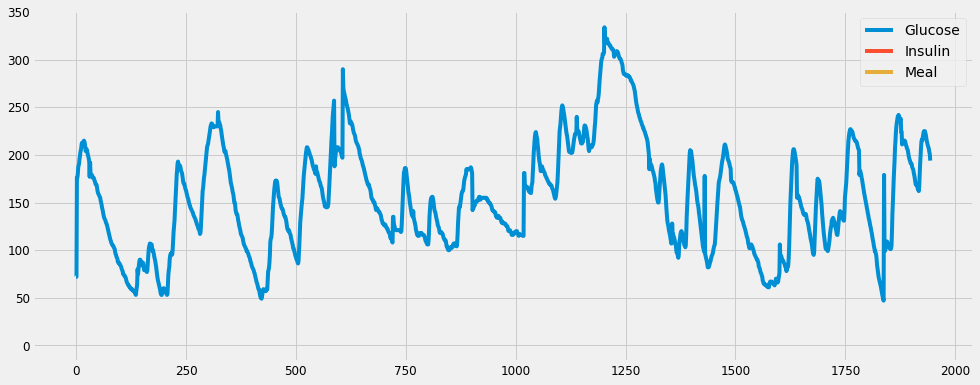

In [304]:
df.plot(figsize=(15,6))
plt.show()

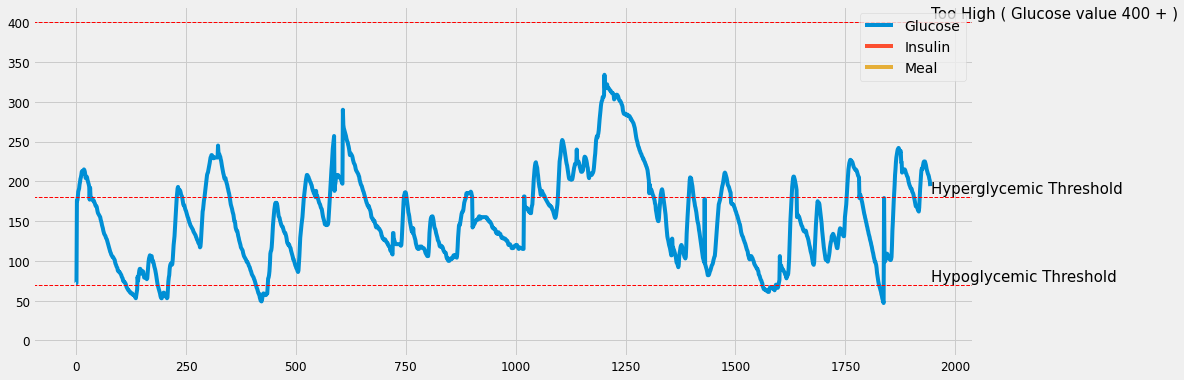

In [305]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [306]:
#df.drop(0,inplace=True)

In [307]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [308]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [309]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [310]:
#interpolate_glucose(df,'Glucose')

In [311]:
#meal

In [312]:
#insul

In [313]:
df['Glucose'].isnull().sum()

0

In [314]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [315]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [316]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [317]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

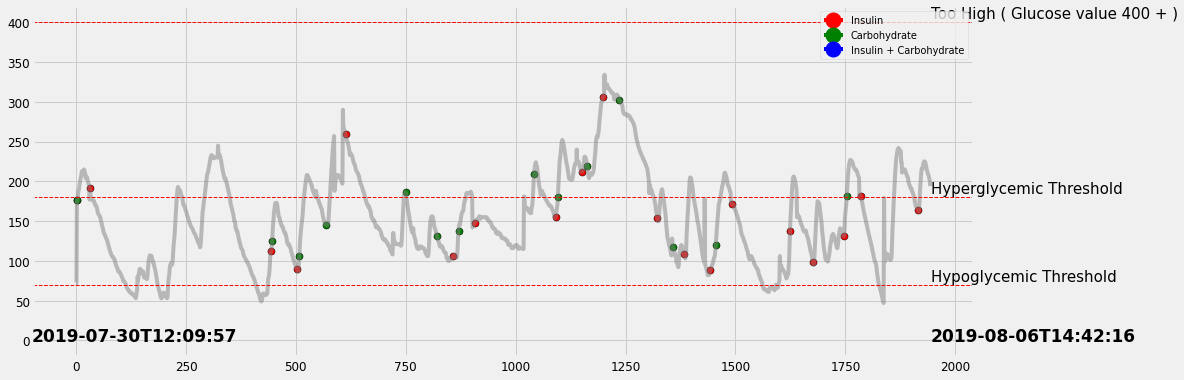

In [318]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [319]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [320]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [321]:
df[1900:1950]

,Timestamp,Event,Glucose,Insulin,Meal
1900,2019-08-06T11:07:17,EGV,191.0,0.0,0.0
1901,2019-08-06T11:12:16,EGV,190.0,0.0,0.0
1902,2019-08-06T11:17:17,EGV,187.0,0.0,0.0
1903,2019-08-06T11:22:16,EGV,186.0,0.0,0.0
1904,2019-08-06T11:27:16,EGV,185.0,0.0,0.0
1905,2019-08-06T11:32:17,EGV,183.0,0.0,0.0
1906,2019-08-06T11:37:17,EGV,180.0,0.0,0.0
1907,2019-08-06T11:42:17,EGV,178.0,0.0,0.0
1908,2019-08-06T11:47:17,EGV,175.0,0.0,0.0
1909,2019-08-06T11:52:16,EGV,172.0,0.0,0.0


In [322]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [323]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [324]:
import numpy as np
import tensorflow as tf
import random as rn

In [325]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [326]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [327]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [328]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

## 나이브 메소드

### 예를 들어 단순히 t 시점에 t - 6 (sampling rate가 5분이므로 30분), t + 1 시점에 t - 5값을 가져오는 naive한 방법

In [329]:
raw_seq = df['Glucose']
#raw_seq=raw_seq.to_numpy(dtype='int64')

In [330]:
new_list = []
for i in range(len(raw_seq)):
  if i < 6:
    new_list.append(raw_seq[i])
  else:
    new_list.append(raw_seq[i-6])
  
  


  

In [331]:
len(new_list)

1944

In [125]:
len(raw_seq)

1045

In [132]:
raw_seq[1030:1045]

1030    246.0
1031    246.0
1032    247.0
1033    244.0
1034    241.0
1035    236.0
1036    231.0
1037    229.0
1038    226.0
1039    216.0
1040    206.0
1041    199.0
1042    190.0
1043    194.0
1044    181.0
Name: Glucose, dtype: float64

In [133]:
new_list[1030:1045]

[275.0,
 265.0,
 261.0,
 254.0,
 251.0,
 249.0,
 246.0,
 246.0,
 247.0,
 244.0,
 241.0,
 236.0,
 231.0,
 229.0,
 226.0]

In [332]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [333]:
# 30분
RMSE(new_list,raw_seq)

20.054914322364137

In [334]:
# 15분
new_list = []
for i in range(len(raw_seq)):
  if i < 3:
    new_list.append(raw_seq[i])
  else:
    new_list.append(raw_seq[i-3])
  
  


  

In [335]:
RMSE(new_list,raw_seq)

12.505513187482732

In [336]:
# 60분
new_list = []
for i in range(len(raw_seq)):
  if i < 12:
    new_list.append(raw_seq[i])
  else:
    new_list.append(raw_seq[i-12])
  

In [337]:
RMSE(new_list,raw_seq)

32.272422581195535

In [120]:
new_list[1:15]

[120.0,
 115.0,
 126.0,
 135.0,
 139.0,
 134.0,
 120.0,
 113.0,
 106.0,
 101.0,
 94.0,
 90.0,
 88.0,
 81.0]

In [121]:
raw_seq[1:15]

1     120.0
2     115.0
3     126.0
4     135.0
5     139.0
6     143.0
7     150.0
8     156.0
9     150.0
10    144.0
11    144.0
12    134.0
13    120.0
14    113.0
Name: Glucose, dtype: float64